# World Happiness Report

The World Happiness Report is an annual landmark survey of the state of global happiness (155 countries). Governments, civil society, organizations, and policymakers use these reports to evaluate the progress and well-being of nations to explain variations in happiness.  The happiness scores, collected from the Gallup World Poll, follow a rating scale of 0 to 10, with 0 being the worst and 10 being the best possible life of the current lives of the respondents. We will explore whether the well-being of the countries – economy, family, health, freedom, trust of the government, and generosity – contributes to their state of happiness and how the scores would compare if they were in Dystopia, a hypothetical country with the world's lowest national averages.

In [1]:
%matplotlib inline

import warnings
from zipfile import ZipFile

import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import HTML, Javascript, display
from matplotlib import pyplot as plt
from plotly import express as px, graph_objs as go
from scipy import stats
from scipy.spatial import distance
from scipy.stats import chi2


warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 8
plt.rcParams['figure.titlesize'] = 10
plt.rcParams['axes.linewidth'] = 0.1
plt.rcParams['patch.linewidth'] = 0

display(HTML("<style>.container { width:100% !important; }</style>"))

### Load and Clean Data

In [2]:
files = ZipFile('data/happy.zip')
whr_2015, whr_2016, whr_2017, whr_2018, whr_2019 = \
    [pd.read_csv(files.open(f)) for f in np.sort(files.namelist())[:-5]]

In [3]:
# # print column names of each dataset
# for df in [whr_2015, whr_2016, whr_2017, whr_2018, whr_2019]:
#     print(np.array(df.columns))

In [4]:
# Make columns consistent across all datasets
whr_2015['Year'] = '2015'
whr_2016['Year'] = '2016'
whr_2017['Year'] = '2017'
whr_2018['Year'] = '2018'
whr_2019['Year'] = '2019'

whr_2015 = whr_2015.drop(columns=['Standard Error'])
whr_2016 = whr_2016.drop(
    columns=['Lower Confidence Interval', 'Upper Confidence Interval'])
whr_2017 = whr_2017.rename(columns={'Happiness.Rank': 'Happiness Rank',
                                    'Happiness.Score': 'Happiness Score',
                                    'Economy..GDP.per.Capita.': 'Economy (GDP per Capita)',
                                    'Health..Life.Expectancy.': 'Health (Life Expectancy)',
                                    'Trust..Government.Corruption.': 'Trust (Government Corruption)',
                                    'Dystopia.Residual': 'Dystopia Residual'}) \
    .drop(columns=['Whisker.high', 'Whisker.low'])
whr_2018 = whr_2018.rename(columns={'Overall rank': 'Happiness Rank',
                                    'Country or region': 'Country',
                                    'Score': 'Happiness Score',
                                    'GDP per capita': 'Economy (GDP per Capita)',
                                    'Social support': 'Family',
                                    'Healthy life expectancy': 'Health (Life Expectancy)',
                                    'Freedom to make life choices': 'Freedom',
                                    'Perceptions of corruption': 'Trust (Government Corruption)'})
whr_2019 = whr_2019.rename(columns={'Overall rank': 'Happiness Rank',
                                    'Country or region': 'Country',
                                    'Score': 'Happiness Score',
                                    'GDP per capita': 'Economy (GDP per Capita)',
                                    'Social support': 'Family',
                                    'Healthy life expectancy': 'Health (Life Expectancy)',
                                    'Freedom to make life choices': 'Freedom',
                                    'Perceptions of corruption': 'Trust (Government Corruption)'})

# Create one dataframe that contains all of 2015-2019 data
happy = pd.concat([whr_2015, whr_2016, whr_2017,
                  whr_2018, whr_2019], ignore_index=True)
# happy.head()

In [5]:
# match column names


def region(country):
    """ Get region name based on 2015 dataset """
    try:  # if region name is in 2015 dataset, add name to region column
        region_name = list(
            whr_2015.loc[whr_2015['Country'] == country]['Region'])[0]
        return region_name
    except IndexError:  # if region name is not in 2015 dataset, add empty string to region column
        return ''


happy['Region'] = happy['Country'].apply(region)
non_reg = happy[happy['Country'].isin(
    whr_2015['Country'].unique()) == False]['Country'].unique().tolist()
print(f'Regions in happy not in 2015 dataset: \n{non_reg} ')

Regions in happy not in 2015 dataset: 
['Puerto Rico', 'Belize', 'Somalia', 'Somaliland Region', 'Namibia', 'South Sudan', 'Taiwan Province of China', 'Hong Kong S.A.R., China', 'Trinidad & Tobago', 'Northern Cyprus', 'North Macedonia', 'Gambia'] 


In [6]:
# assign countries with missing regions from 2015 dataset with their regions
def region_name(region, countries):
    for c in countries:
        happy.loc[happy['Country'] == c, 'Region'] = region


region_name('Latin America and Caribbean', [
            'Puerto Rico', 'Belize', 'Trinidad & Tobago'])
region_name('Sub-Saharan Africa',
            ['Somalia', 'Somaliland Region', 'Namibia', 'South Sudan', 'Gambia'])
region_name('Eastern Asia',                [
            'Taiwan Province of China', 'Hong Kong S.A.R., China'])
region_name('Central and Eastern Europe',  [
            'Northern Cyprus', 'North Macedonia'])

# Replace NaN values with 0 to prevent future problems
happy = happy.fillna(0)

In [7]:
# Standardized happy dataframe
happy_su = (happy - happy.drop(['Year'], axis=1).mean()) / happy.std()
happy_su = happy_su.drop(['Country', 'Region', 'Year'], axis=1) \
                   .merge(happy[['Country', 'Region', 'Year']],
                          left_index=True, right_index=True)[happy.columns]

### Exploratory Data Analysis

Europe, North America, Australia, and New Zealand seem to have the highest Happiness Scores, likely from their economic development and social structure. These countries or regions tend to be well-developed with sufficient housing, education, healthcare, and other basic needs. Residents usually have well-paying jobs to live comfortably.

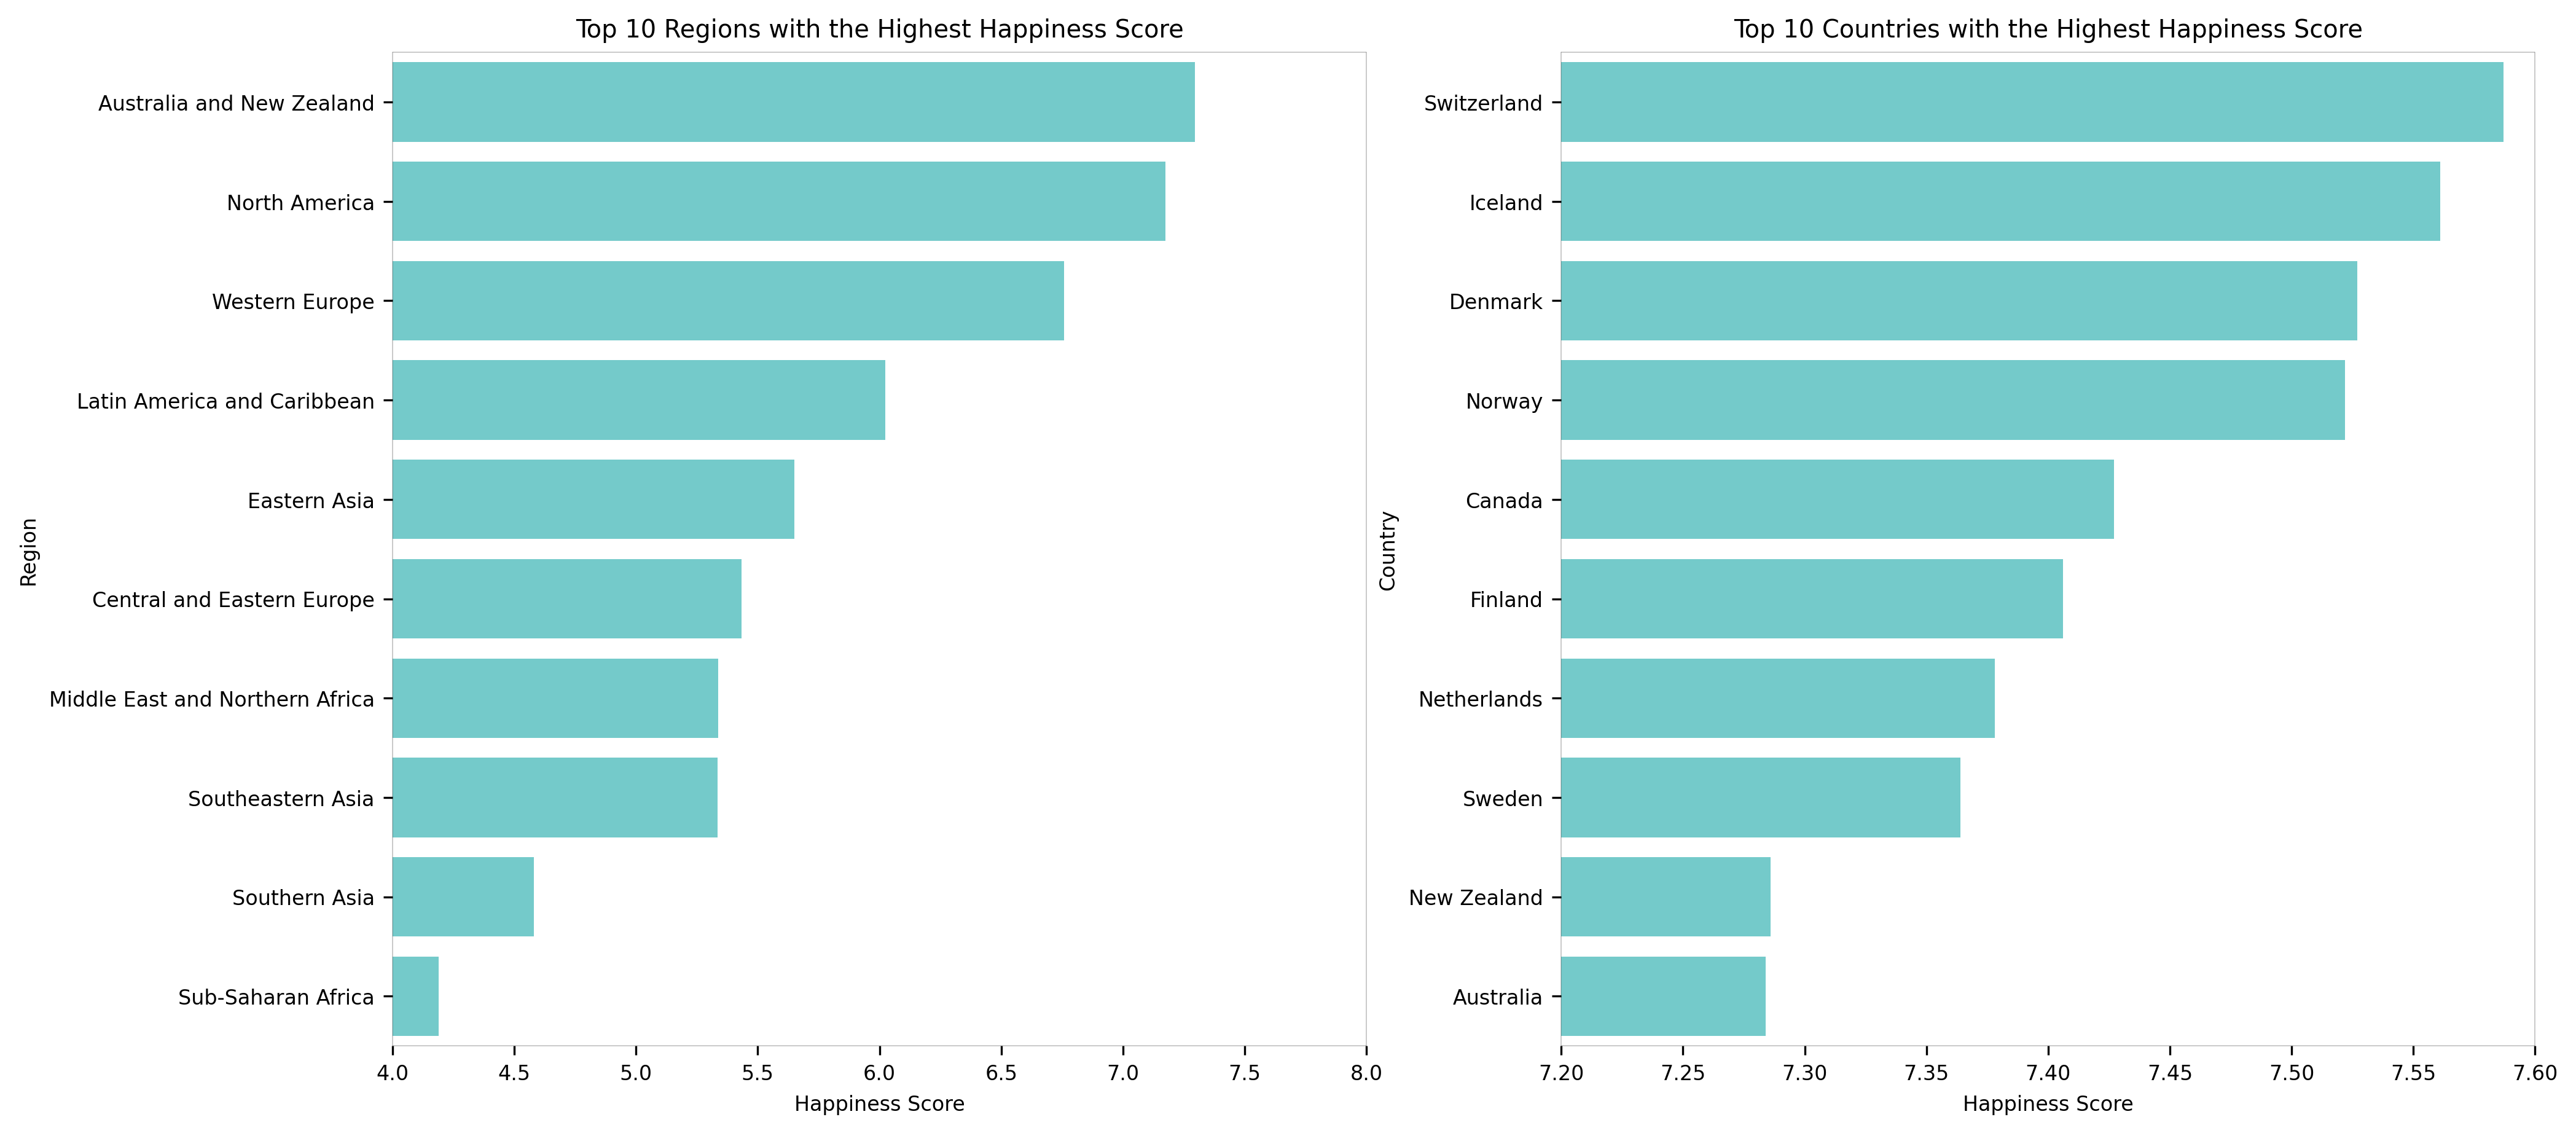

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 7))

sns.barplot(x='Happiness Score', y='Region',
            data=happy.groupby('Region', as_index=False).mean(
            ).sort_values('Happiness Score', ascending=False),
            orient='h', color='c', alpha=0.6, ax=axs[0])
axs[0].set_title('Top 10 Regions with the Highest Happiness Score')
axs[0].set_xlim(4, 8)

sns.barplot(x='Happiness Score', y='Country',
            data=happy[:10].sort_values('Happiness Score', ascending=False),
            orient='h', color='c', alpha=0.6, ax=axs[1])
axs[1].set_title('Top 10 Countries with the Highest Happiness Score')
axs[1].set_xlim(7.2, 7.6)
plt.show()

#### Correlation Matrix
Each determining factor of a region's happiness rank/score is weighted differently. For instance, trust in government seems to be the most correlated for Western Europe and North America, while the economy is the most correlated for the other two regions.

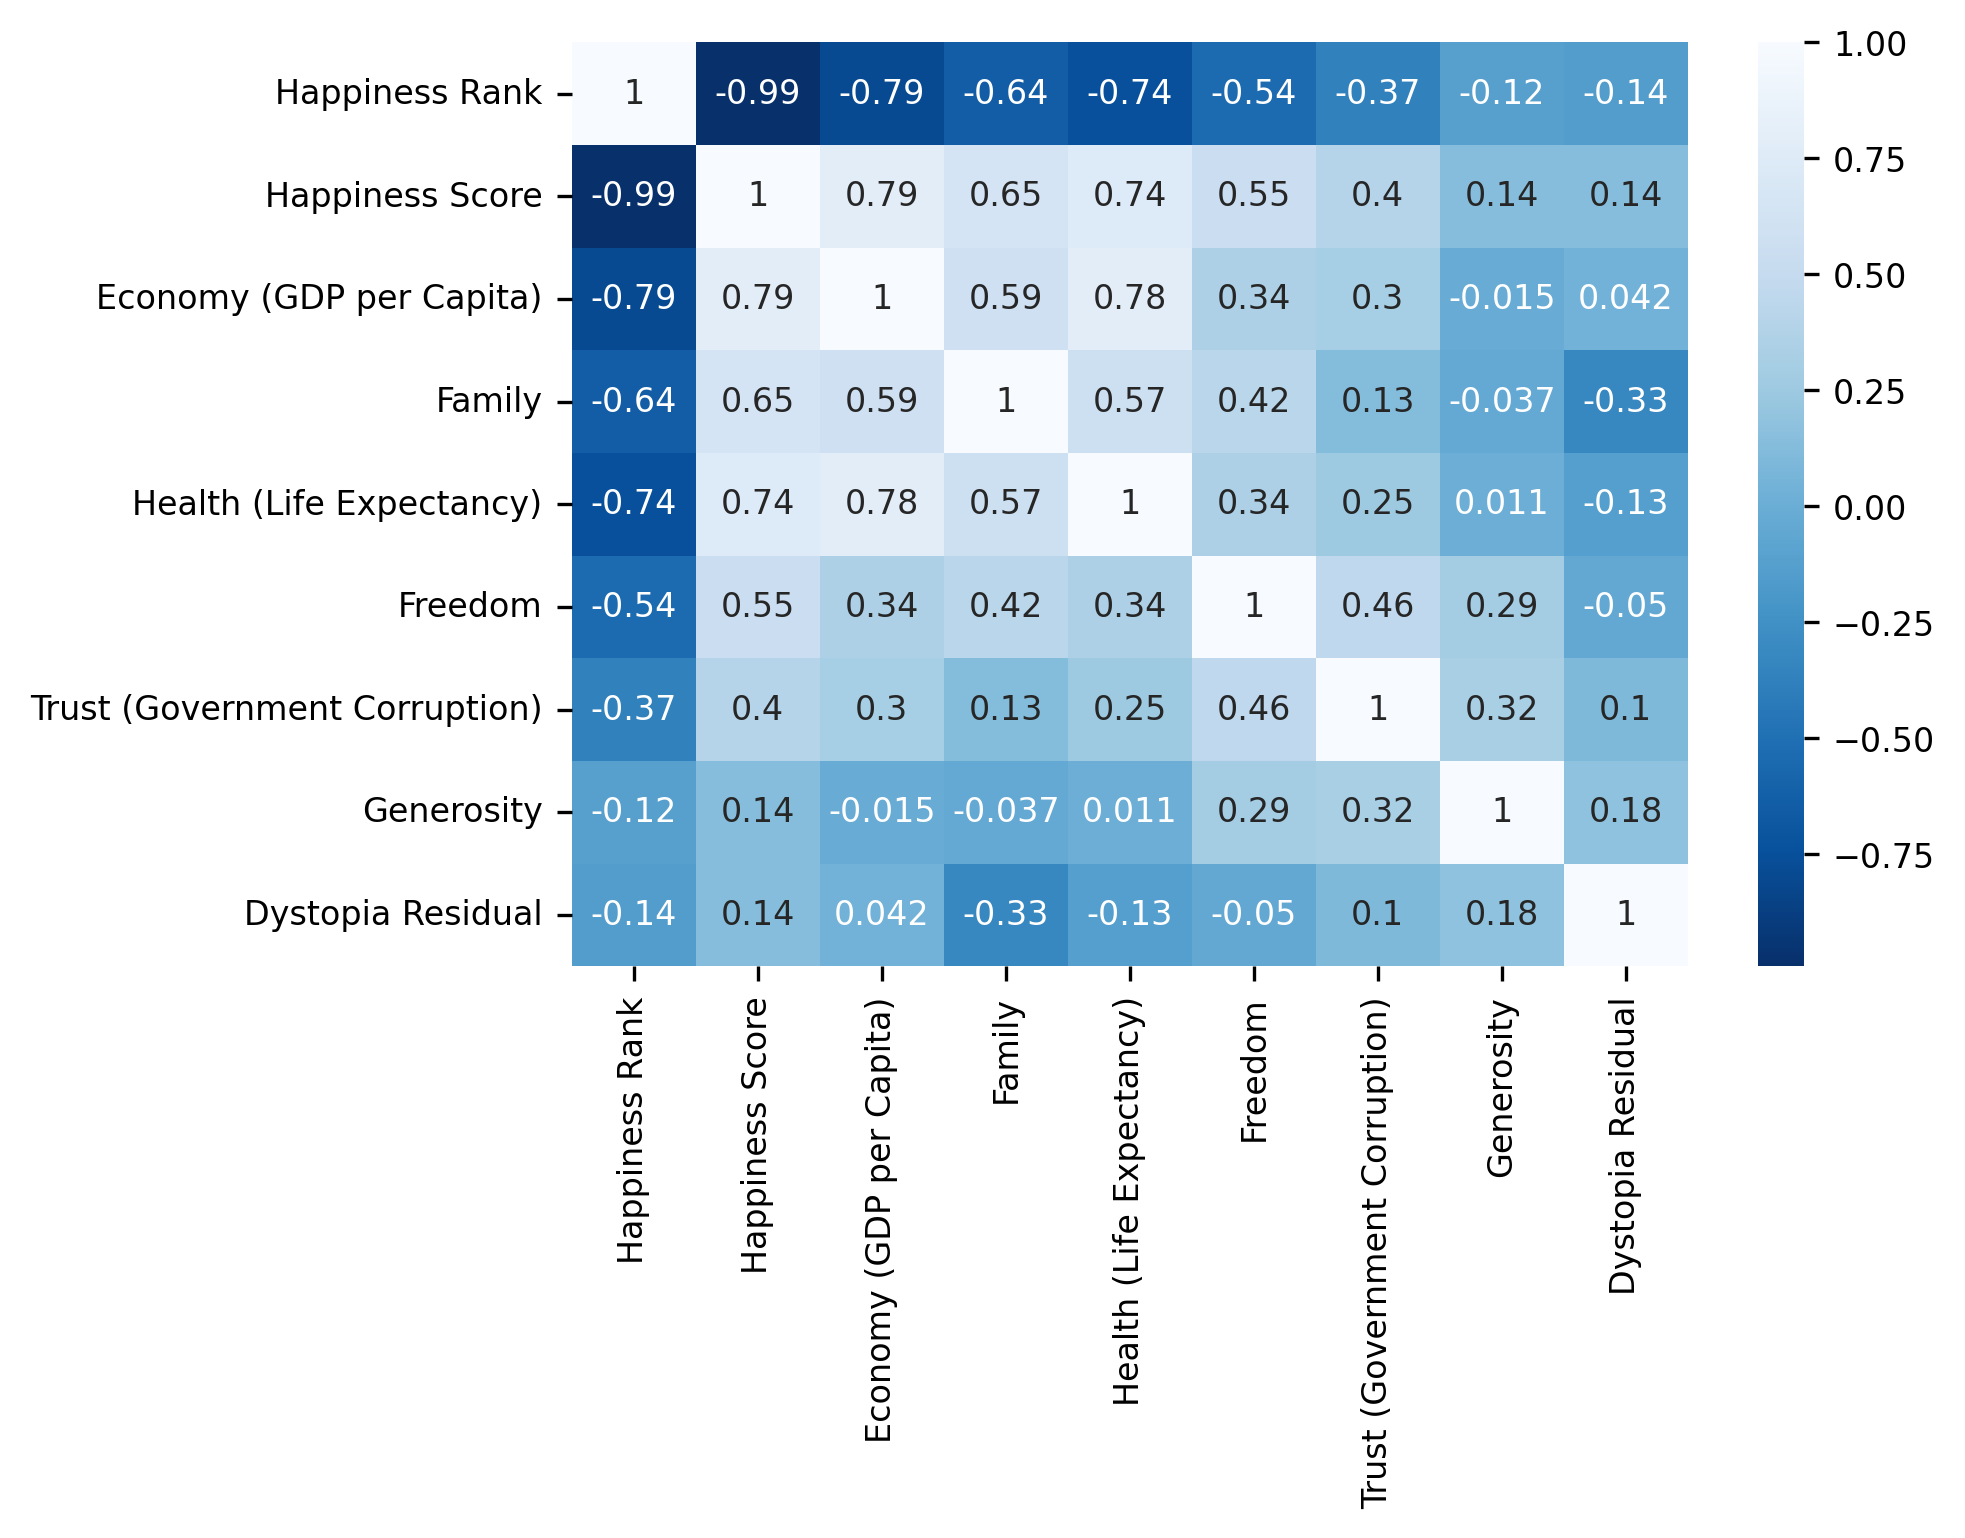

In [9]:
# Overall Correlation
sns.heatmap(happy.corr(), cmap='Blues_r', annot=True)
plt.show()

In [10]:
# Correlation by Region
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(
    30, 30), constrained_layout=True)
sns.heatmap(happy[happy['Region'] == 'Western Europe'].corr(),
            cmap='Blues_r', annot=True, ax=axs[0, 0])
axs[0, 0].set_title('Western Europe')
sns.heatmap(happy[happy['Region'] == 'Eastern Asia'].corr(),
            cmap='Reds_r', annot=True, ax=axs[0, 1])
axs[0, 1].set_title('Eastern Asia')
sns.heatmap(happy[happy['Region'] == 'North America'].corr(),
            cmap='Greens_r', annot=True, ax=axs[1, 0])
axs[1, 0].set_title('North America')
sns.heatmap(happy[happy['Region'] == 'Middle East and Northern Africa'].corr(
), cmap='Purples_r', annot=True, ax=axs[1, 1])
axs[1, 1].set_title('Middle East and Northern Africa')
fig.suptitle('Correlation Matrix by Country')
plt.show()

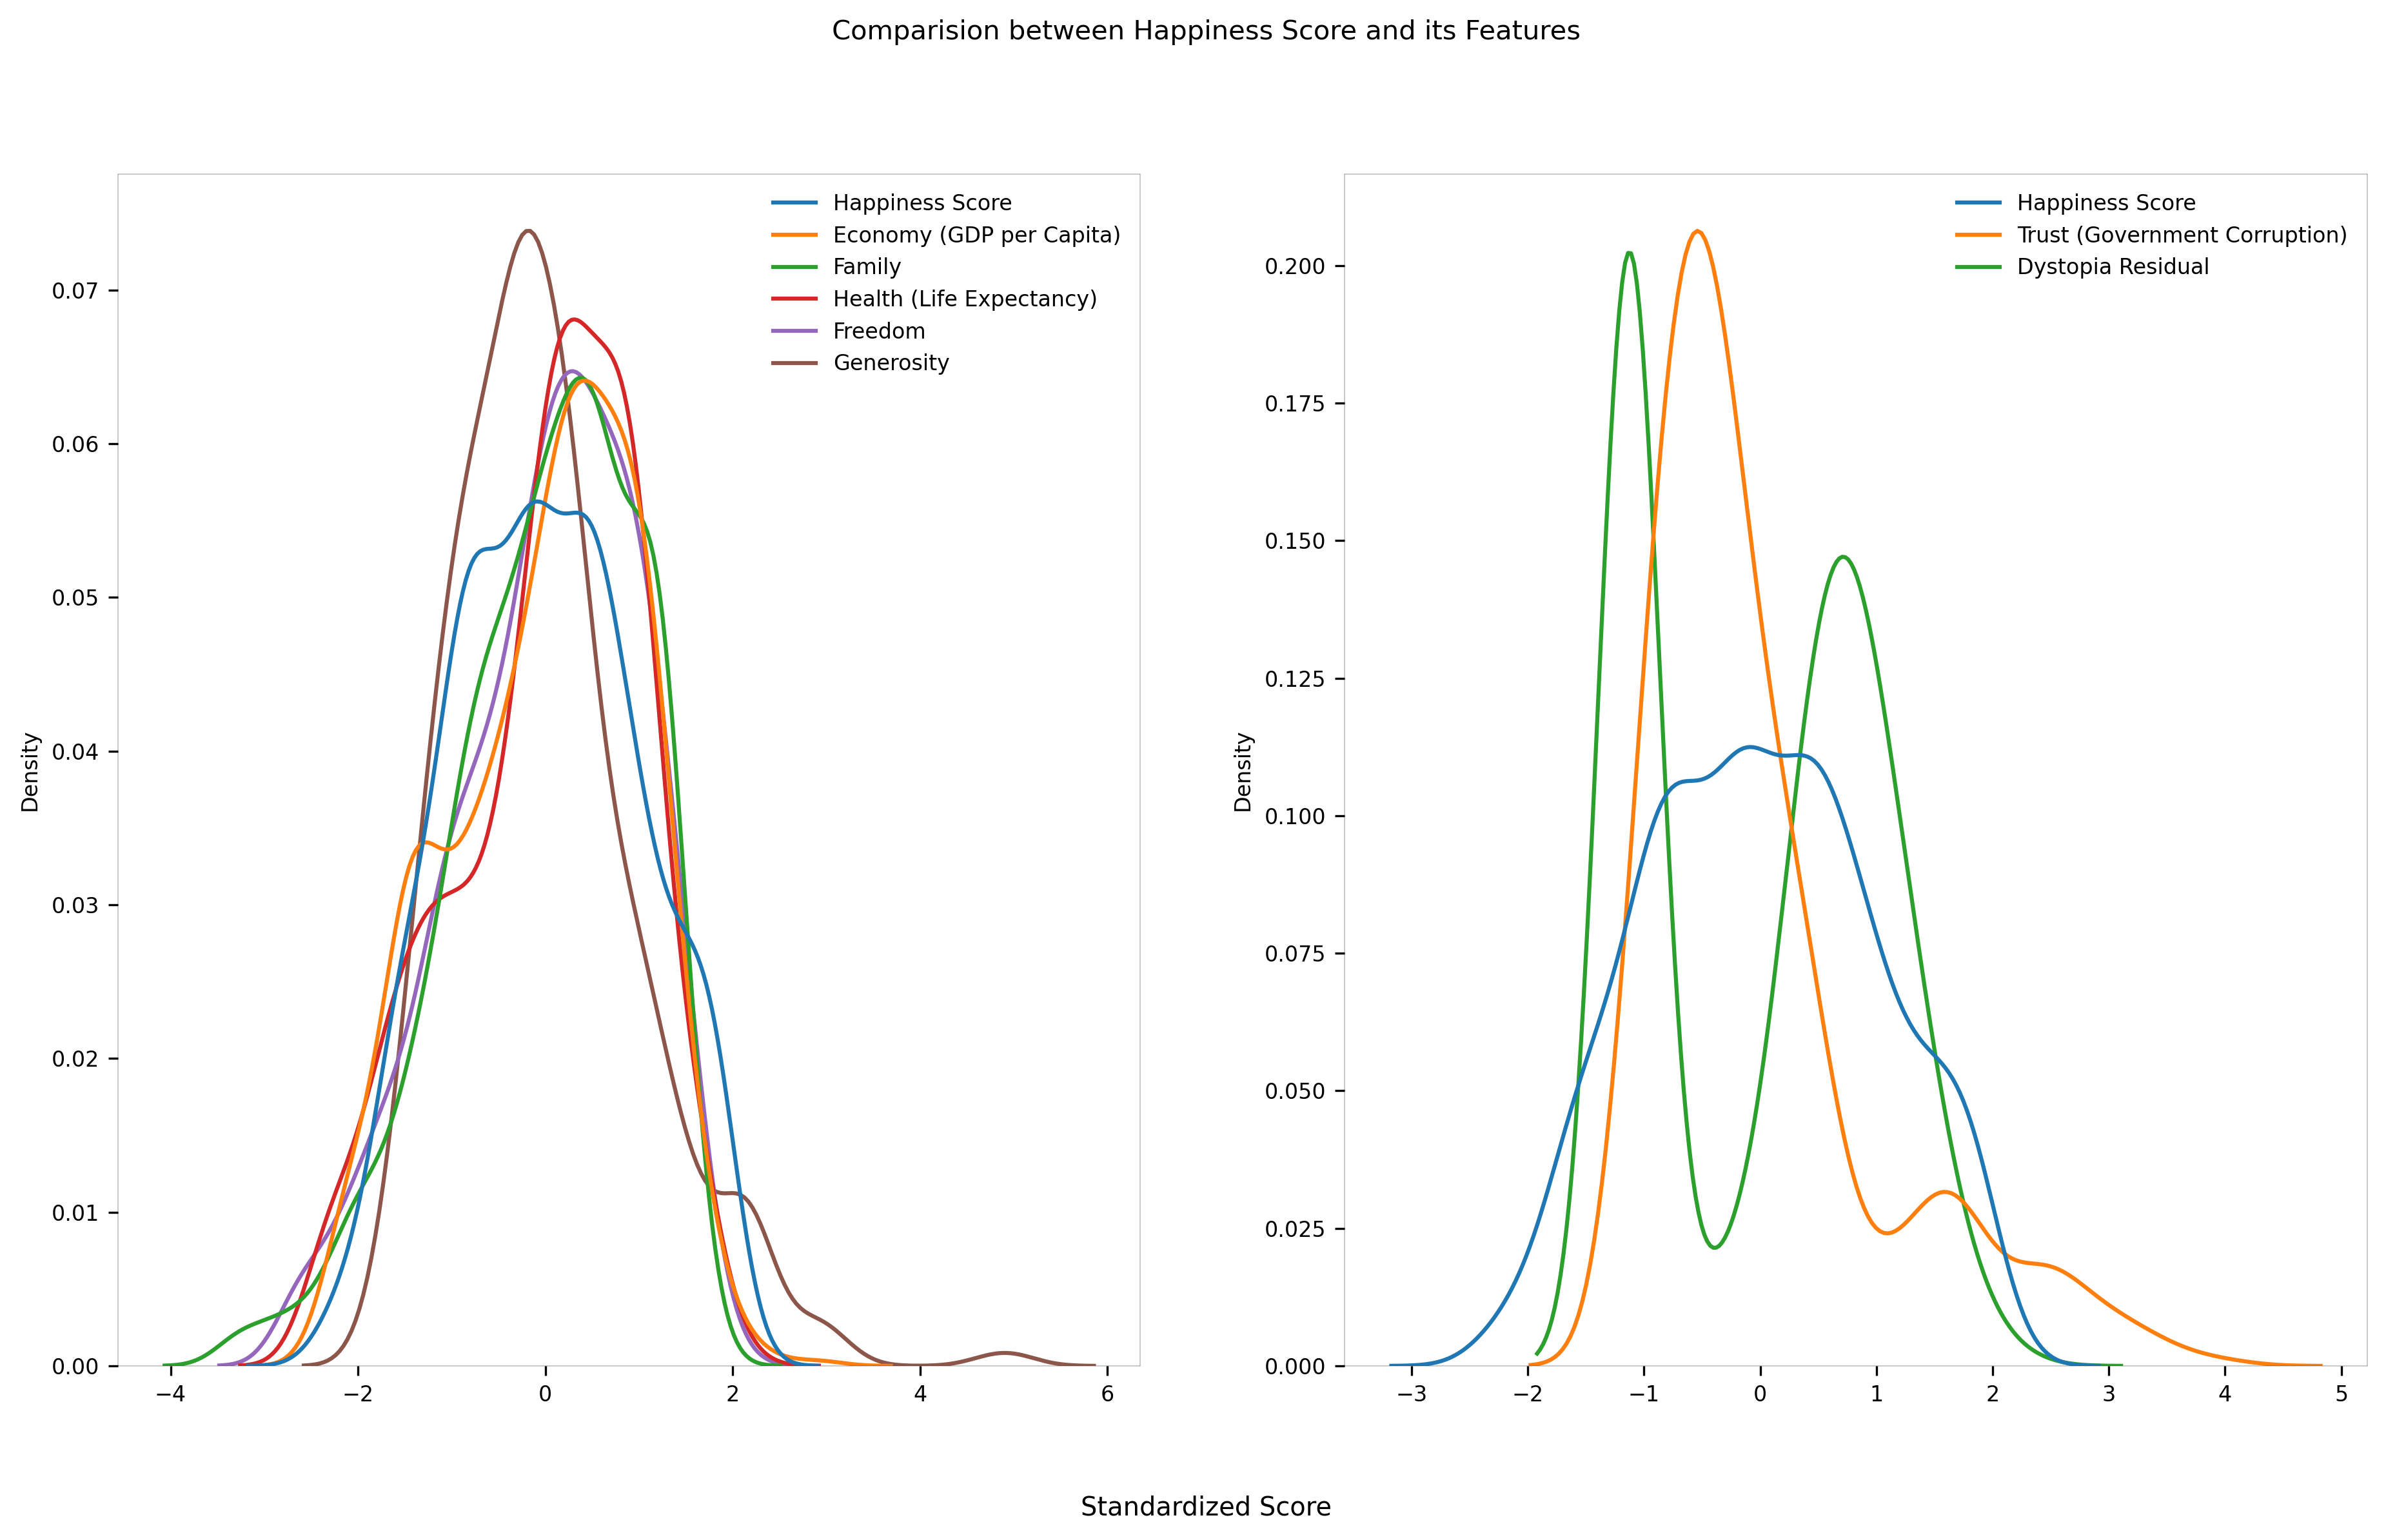

In [11]:
# KDE Plot: distrubition of each factor
fig, axs = plt.subplots(ncols=2, figsize=(15, 8))
# Stronger Correlation
sns.kdeplot(data=happy_su.drop(columns=[
            'Happiness Rank', 'Trust (Government Corruption)', 'Dystopia Residual']), ax=axs[0])
# Weaker Correlation
sns.kdeplot(data=happy_su[[
            'Happiness Score', 'Trust (Government Corruption)', 'Dystopia Residual']], ax=axs[1])
fig.suptitle('Comparision between Happiness Score and its Features')
fig.supxlabel('Standardized Score')
plt.show()

In [12]:
fig = px.scatter(happy[happy['Happiness Rank'] <= 20], x='Happiness Rank', y='Happiness Score',
                 color='Year', title='Top 20 Happiness Ranks from 2015 to 2019',
                 hover_data={'Country': True,
                             'Happiness Rank': False})
fig.show()
# fig.show('png')

In [13]:
feature = 'Family'

fig = px.choropleth(happy, locations='Country', locationmode='country names',
                    color=feature, color_continuous_scale='Ice', animation_frame='Year',
                    hover_name='Country', hover_data=['Happiness Rank', 'Happiness Score'],
                    title=f'{feature} Changes')

# fig["layout"].pop("updatemenus") # drop animation buttons
fig.show()
# fig.show('png')

#### Plot Multiple Features
Countries with a better economy and higher health or life expectancy seem to have higher happiness scores.

In [14]:
x_col = 'Economy (GDP per Capita)'
y_col = 'Health (Life Expectancy)'
fig = px.scatter(happy, x=x_col, y=y_col,
                 animation_frame='Year', animation_group='Country',
                 size=(happy['Happiness Score'])**3, color='Region', size_max=15,
                 hover_name='Country', hover_data=['Happiness Rank', 'Happiness Score'],
                 title=f'Happiness Change ({x_col} and {y_col})')

# fig["layout"].pop("updatemenus") # drop animation buttons
fig.show()
# fig.show('png')

#### Identify Outliers
Countries with low happiness scores tend to be outliers.

In [15]:
z_score = np.abs(stats.zscore(happy['Happiness Score'])) > 2
happy_out = happy[z_score]
happy_out.head(2)

Country                           Region  Happiness Rank  \
155    Syria  Middle East and Northern Africa             156   
156  Burundi               Sub-Saharan Africa             157   

     Happiness Score  Economy (GDP per Capita)   Family  \
155            3.006                    0.6632  0.47489   
156            2.905                    0.0153  0.41587   

     Health (Life Expectancy)  Freedom  Trust (Government Corruption)  \
155                   0.72193  0.15684                        0.18906   
156                   0.22396  0.11850                        0.10062   

     Generosity  Dystopia Residual  Year  
155     0.47179            0.32858  2015  
156     0.19727            1.83302  2015

[Mahalanobis Distance](https://towardsdatascience.com/multivariate-outlier-detection-in-python-e946cfc843b3): find outliers for multiple variables

In [16]:

feat1 = 'Happiness Score'
feat2 = 'Freedom'

isolated_happy = happy.loc[happy['Year'] == '2019'][[feat1, feat2]]

centerpoint = np.mean(isolated_happy)
print('Centerpoints:')
print(centerpoint)


covariance = np.cov(isolated_happy, rowvar=False)
covaraince_inv = np.linalg.matrix_power(covariance, -1)

lambda_, v = np.linalg.eig(covariance)
lambda_ = np.sqrt(lambda_)

feature_tuples = zip(isolated_happy[feat1], isolated_happy[feat2])
distances = []
for feature_pair in feature_tuples:
    distances.append(distance.mahalanobis(
        feature_pair, centerpoint, covaraince_inv))
distances = np.array(distances)

# Outliers from Chi-Sqaure
cutoff = chi2.ppf(0.95, isolated_happy.shape[1]) / 2.5
outlierIndexes = np.where(distances > cutoff)
# happy.loc[happy['Year'] == '2019'].iloc[outlierIndexes].head(2)

Centerpoints:
Happiness Score    5.407096
Freedom            0.392571
dtype: float64


In [17]:
data = go.Scatter(x=isolated_happy[feat1],
                  y=isolated_happy[feat2],
                  mode='markers',
                  name='2019',
                  marker=dict(color='blue'),
                  text=happy.loc[happy['Year'] == '2019'].Country)
layout = dict(title='Outliers of Happiness Score and Freedom (2019)',
              xaxis=dict(title=feat1, ticklen=5, zeroline=False),
              yaxis=dict(title=feat2, ticklen=5, zeroline=False),
              hovermode='x'
              )
fig = go.Figure(data=data, layout=layout)

fig.add_shape(type='circle',
              xref='x', yref='y',
              x0=centerpoint[0]-lambda_[0]*np.sqrt(cutoff)*np.sqrt(2.5), y0=centerpoint[1]-lambda_[1]*np.sqrt(cutoff)*np.sqrt(2.5),
              x1=centerpoint[0]+lambda_[0]*np.sqrt(cutoff)*np.sqrt(2.5), y1=centerpoint[1]+lambda_[1]*np.sqrt(cutoff)*np.sqrt(2.5),
              opacity=0.2,
              fillcolor='blue',
              line_color='blue',
              )

fig.show()
# fig.show('png')

### Distribution of Happiness Score for Each Region

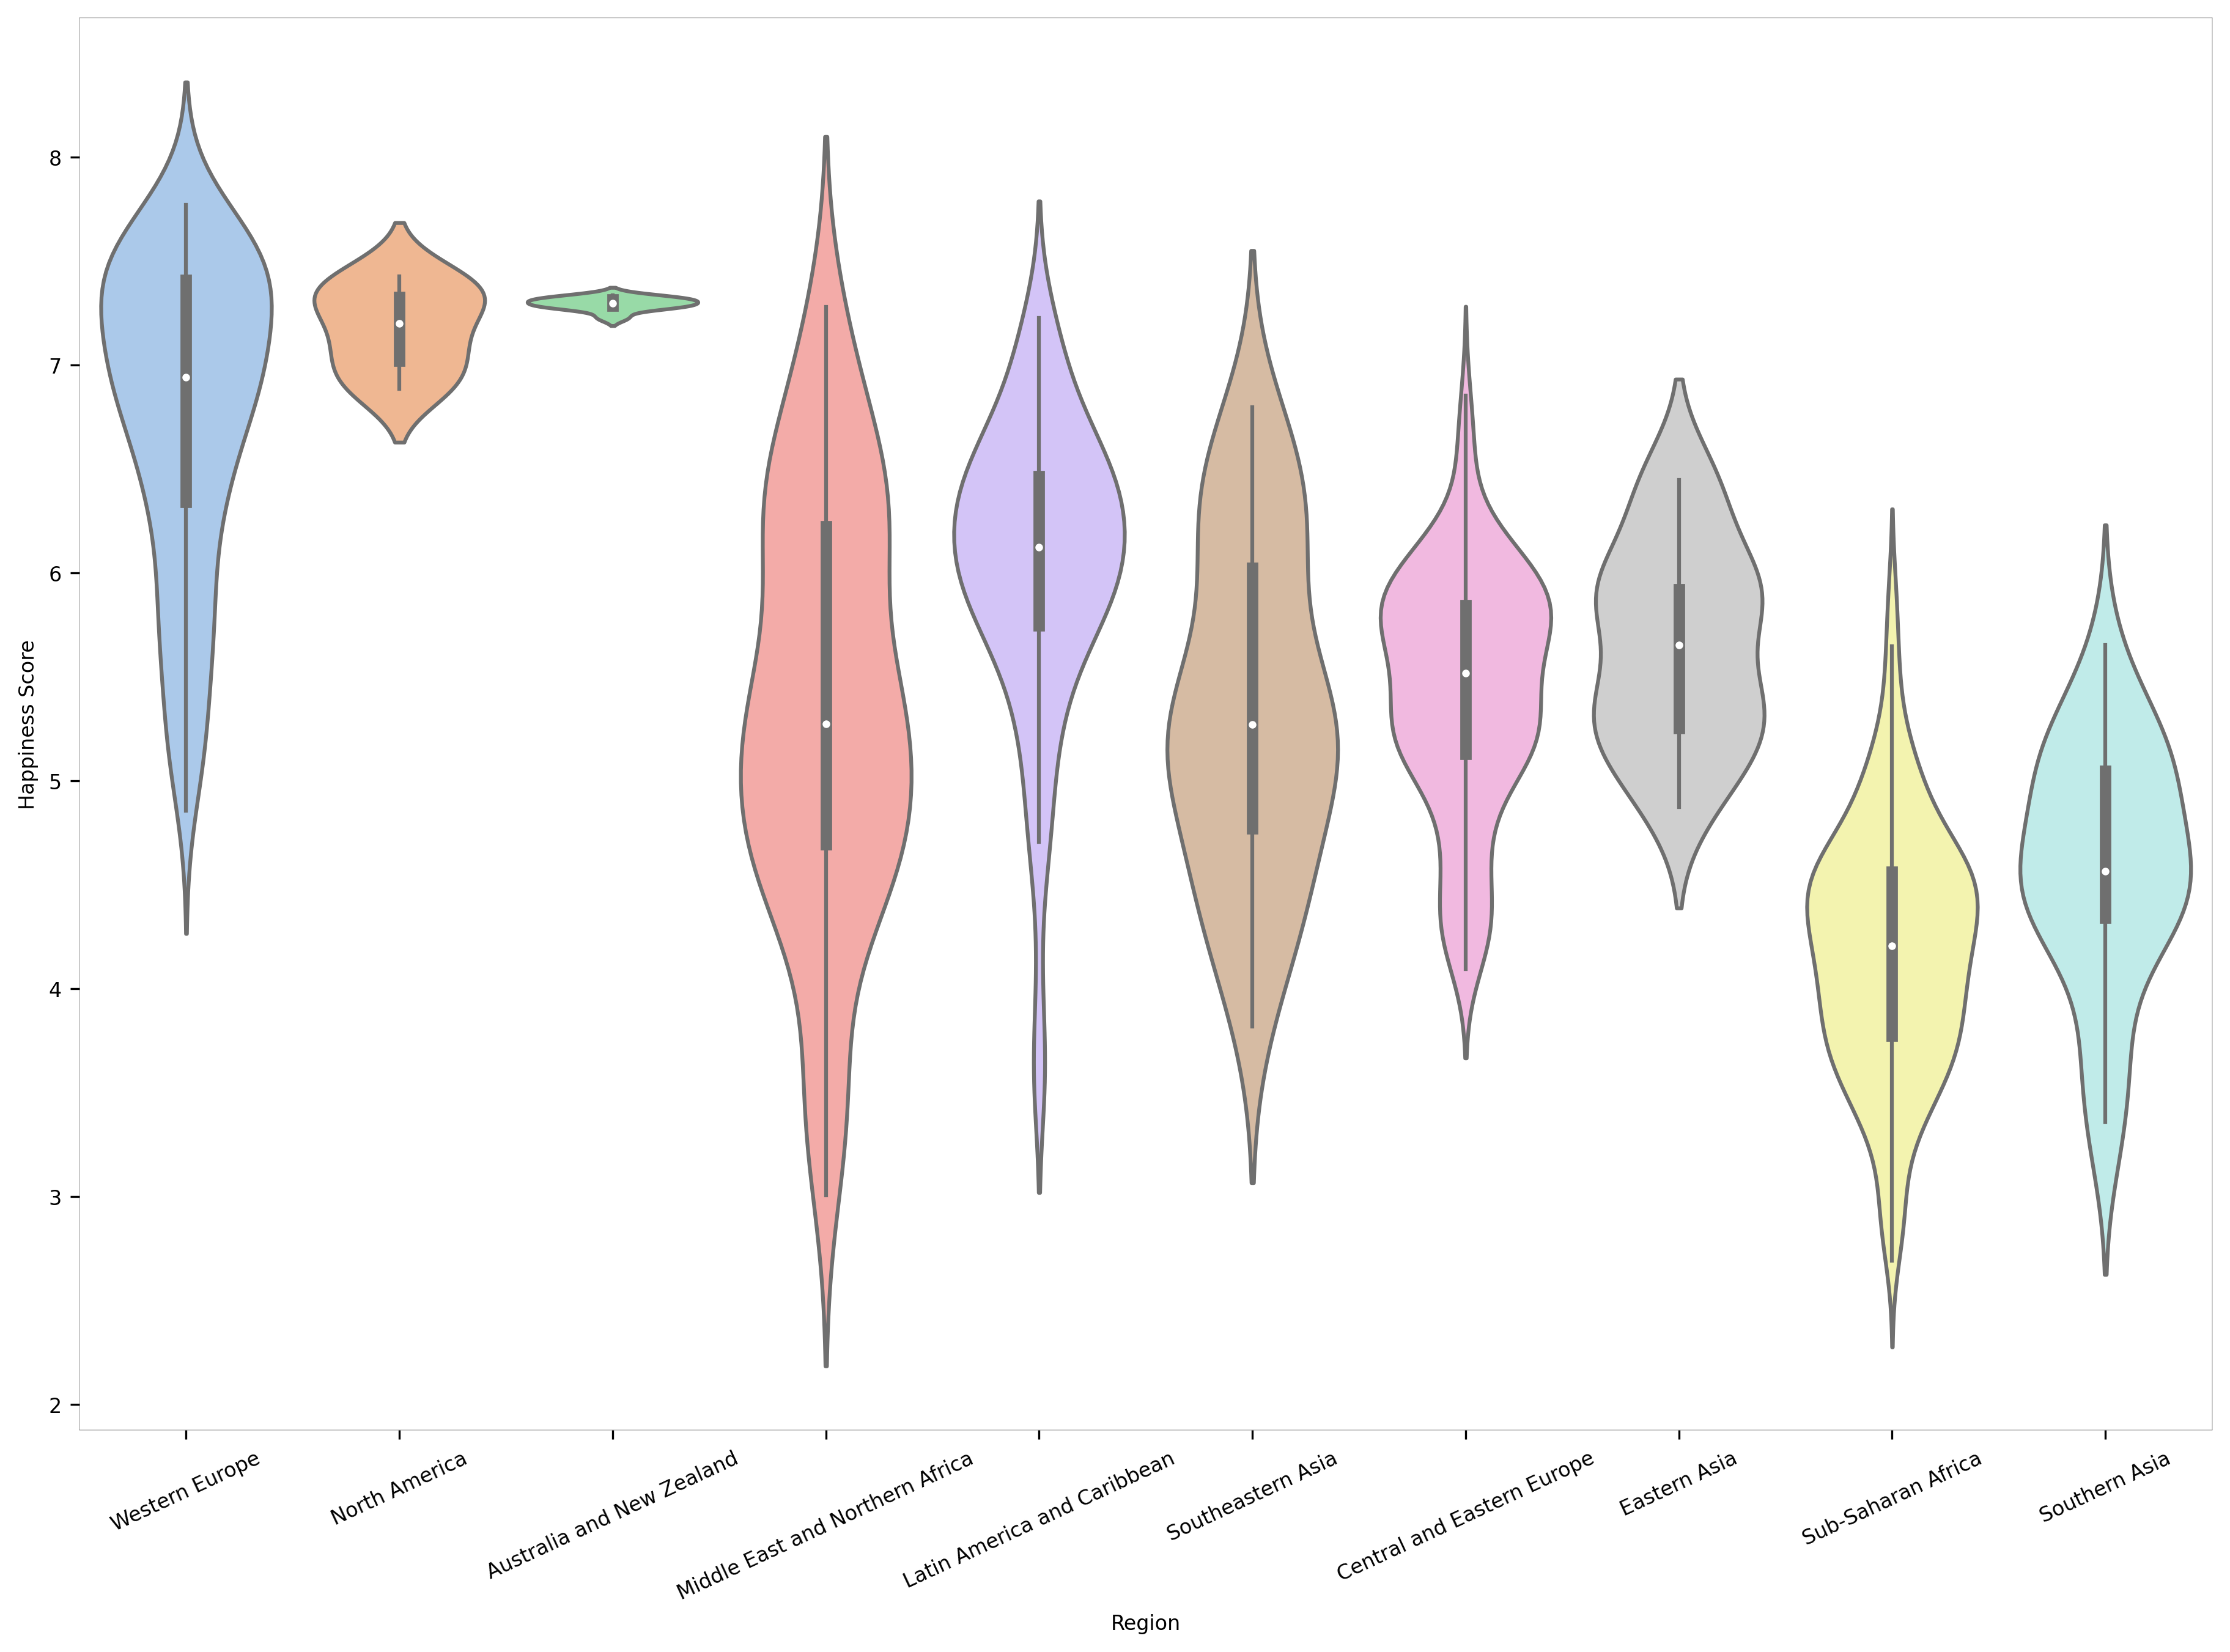

In [18]:
plt.rcParams['figure.figsize'] = (15, 10)
sns.violinplot(data=happy, y='Happiness Score',
               x='Region', scale='width', palette='pastel')
plt.xticks(rotation=25)
plt.show()

In [ ]:
# save notebook
display(Javascript('IPython.notebook.save_checkpoint();'))
# save notebook as html to eugpoon.github.io/projects
!jupyter nbconvert  happy.ipynb --to html
%mv "happy.html" "../eugpoon.github.io/projects/"
# restyle imports, clear output, replace file
!cleanipynb happy.ipynb
# restart kernel
display(HTML("<script>Jupyter.notebook.kernel.restart()</script>"))